# AML 2024  
## CMI Assignment 1  
**Due Date: Sep 28, 2024**

### 1) Classifier for Fashion MNIST:
This dataset contains images of 10 types of clothing, shoes, or other material. Your task is to build a classifier for this dataset using CNN.

#### a) Classify each image into one of 3 classes {clothes, shoes and others}.
- i) First label the images in the training and the test dataset using these 3 labels.
- ii) Then, train your neural network to predict one of these 3 labels.
- iii) Finally, show the performance on the test set.

#### b) Show the effect of permuting the image pixels on CNN classifiers, as we saw in the lectures.

**Fashion-MNIST Dataset**: [https://github.com/zalandoresearch/fashion-mnist](https://github.com/zalandoresearch/fashion-mnist)


### 2) Build a Resnet-18 classifier for the Emotion Detection Dataset
[https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer/data](https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer/data)

#### a) First train a classifier from scratch.
*Note: Resnet-18 and other models are built-in PyTorch, and you can use those if you like.*

#### b) Next, fine-tune a pretrained Resnet-18 on this dataset.
As before, PyTorch has a pre-trained Resnet-18 built-in.

#### c) For both cases, show the performance on the Test set, and compare results.

#### d) Note that Resnet expects images to have a size of 224x224 pixels, and color.
You have to pre-process the images in the dataset accordingly.

### Instructions:
- You have to submit a jupyter notebook (`.ipynb`) with all your code and outputs of the code.
- You have to submit a 1-page writeup documenting what you have done.
- You have to upload these files on Moodle, so make sure they are not larger than 8MB.
- Contact the TAs if you face any issues.
- If you don’t include the outputs in the `.ipynb`, you will get partial credit.
- You can work in groups of 2 or 3.
- Only one member of the group should submit the assignment.
- Please mention the names and roll-numbers of all group members.
- You are free to build upon examples shown in class.
- Please check and confirm with the TAs that your submission has been received on time and there are no issues with the uploaded file.
- No requests for re-submitting the assignment later because of any reason will be accepted after the due date.


# Part-1 Classifier for Fashion MNIST:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy
import random

from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader

# set the PseudoRandom Generator Seeds for better reproducibility
# see here for more: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(99)
random.seed(99)
numpy.random.seed(99)

# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Without Data Augmentation

### Load the FashionMNIST dataset and relabel
Observe that we set shuffle=True, which means that data is randomized

In [ ]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
             }

# Custom mapping function for new labels
def map_labels(original_label):
    if original_label in [0, 1, 2, 3, 4, 6]:  # 0 ----> "clothes"
        return 0
    elif original_label in [7,9]:             # 1 ----> "shoes"
        return 1
    else:                                     # 2 ----> "others"
        return 2

# Custom dataset class to override the labels
class CustomFashionMNIST(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.dataset = datasets.FashionMNIST(root=root, train=train, download=True, transform=transform)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, original_label = self.dataset[idx]
        new_label = map_labels(original_label)
        return image, new_label

# Set up data loaders with the custom dataset
train_loader = torch.utils.data.DataLoader(CustomFashionMNIST('../data', train=True, transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.1307,), (0.3081,))
                                          ])),
                                          batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(CustomFashionMNIST('../data', train=False, transform=transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.1307,), (0.3081,))
                                          ])),
                                          batch_size=1000, shuffle=True)


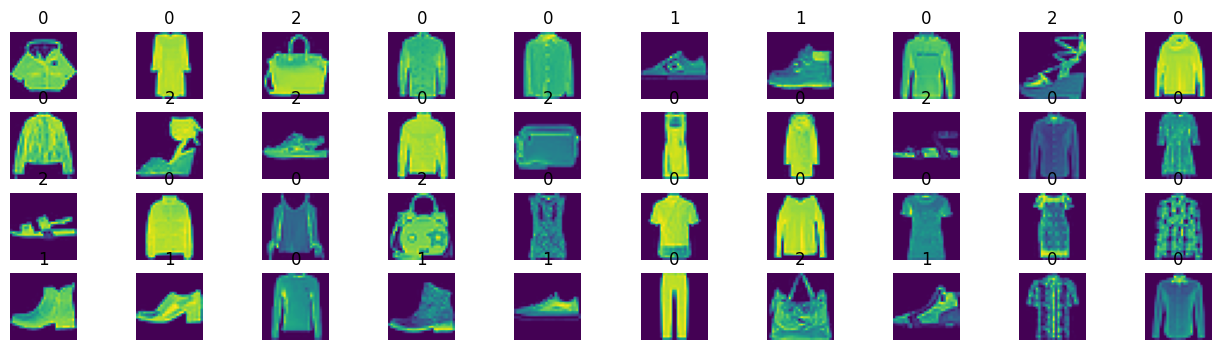

In [ ]:
# show some training images
plt.figure(figsize=(16, 4))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(40):
    image = image_batch[i]
    label = label_batch[i].item()
    plt.subplot(4, 10, i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)

In [ ]:
image_batch, label_batch = next(iter(train_loader))
label_batch

tensor([2, 2, 0, 1, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
        0, 0, 2, 0, 1, 0, 2, 2, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 2,
        0, 0, 0, 1, 0, 0, 0, 2, 2, 1, 0, 0, 1, 0, 2, 0])

### Helper functions for training and testing

In [ ]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

accuracy_list = []

# we pass a model object to this trainer, and it trains this model for one epoch
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        #loss = F.nll_loss(output, target)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        output = model(data)
        #test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

### CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3,padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=6,padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=6,padding=0)
        self.fc1 = nn.Linear(64*4, 200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 64*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

### Train the network

In [ ]:
print("Training on ", device)
model_cnn = CNN(input_size, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 10):
    train(epoch, model_cnn)
    test(model_cnn)

Training on  cuda:0
Number of parameters: 145826
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.296765
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.205059
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.238430
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.145325
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.136355
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.170207
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.085992
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.115272
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.138756
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.095048

Test set: Average loss: 0.2551, Accuracy: 8924/10000 (89%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.238596
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.120001
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.043726
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.089412
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.092064
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.080469
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.015477
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.049716
Tr

### Show some predictions of the test network

In [ ]:
def visualize_pred(img, pred_prob, real_label):
    ''' Function for viewing an image and it's predicted classes.
    '''
    #pred_prob = pred_prob.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.numpy().squeeze())
    ax1.axis('off')
    pred_label = numpy.argmax(pred_prob)
    ax1.set_title([real_label, pred_label])

    ax2.barh(numpy.arange(10), pred_prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(numpy.arange(10))
    ax2.set_yticklabels(numpy.arange(10))
    ax2.set_title('Prediction Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

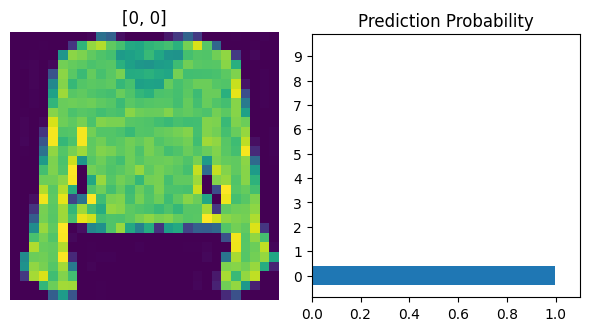

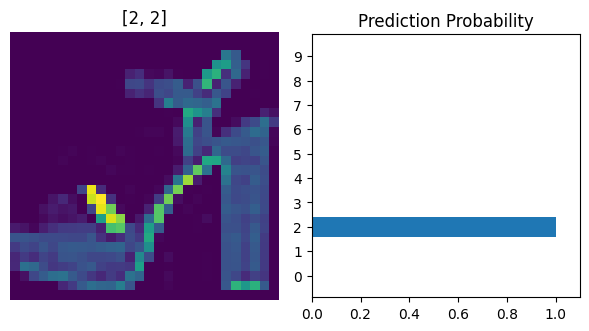

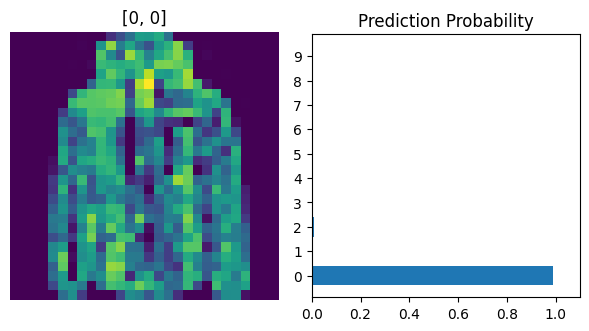

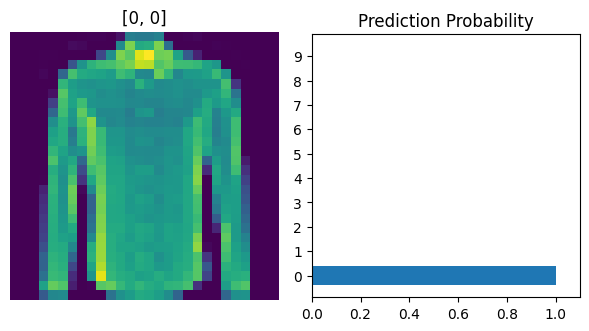

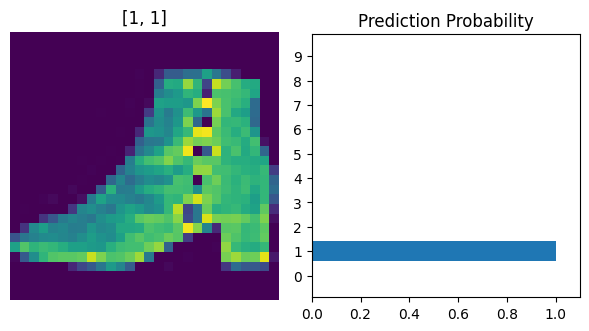

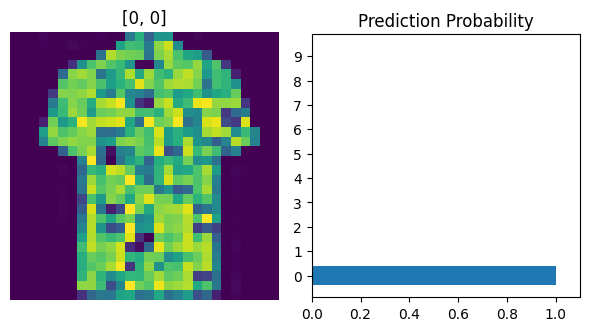

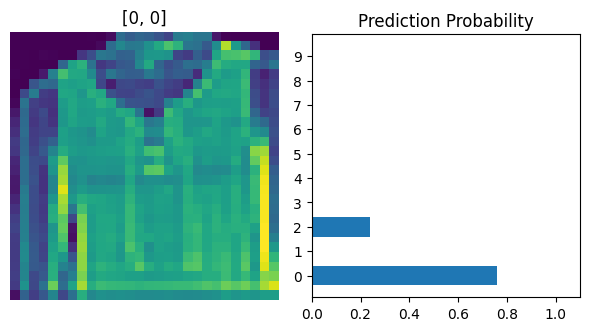

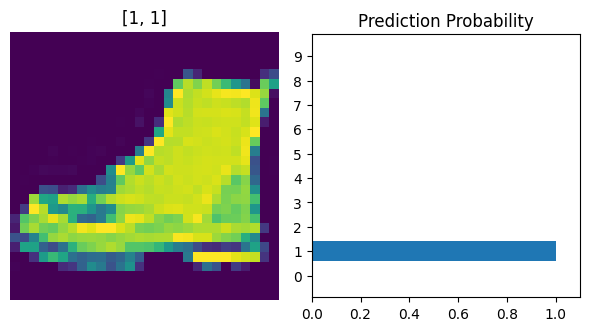

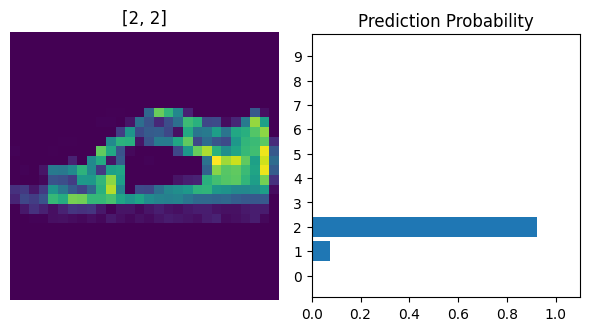

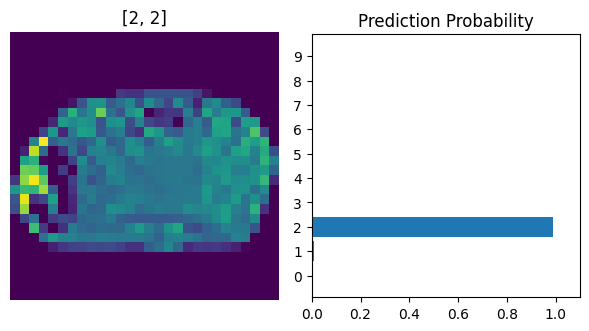

In [ ]:
model_cnn.to('cpu')

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_cnn(image_batch)
for i in range(10):
    img = image_batch[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)

### Network with Dropout

In [ ]:
class CNNDropout(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNNDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3,padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=6,padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=6,padding=0)
        self.fc1 = nn.Linear(64*4, 200)
        self.do1 = nn.Dropout2d(p=0.5)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 64*4)
        x = self.fc1(x)
        x = self.do1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
print("Training on ", device)
model_2 = CNNDropout(input_size, output_size)
model_2.to(device)
optimizer = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_2)))

for epoch in range(0, 10):
    model_2.train() # model in training mode. Turns on dropout, batch-norm etc during training
    train(epoch, model_2)
    model_2.eval() # model in evaluation mode. Turn off dropout, batch-norm etc during validation/testing
    test(model_2)

Training on  cuda:0
Number of parameters: 145826
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.319653


/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.355217
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.263944
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.174534
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.180519
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.455499
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.111028
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.155516
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.063887
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.167929

Test set: Average loss: 0.1043, Accuracy: 9644/10000 (96%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.113683
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.182310
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.065765
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.130720
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.022195
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.052478
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.155657
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.072778
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.101898
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.097

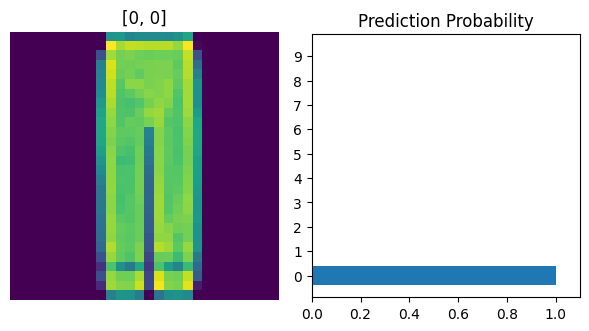

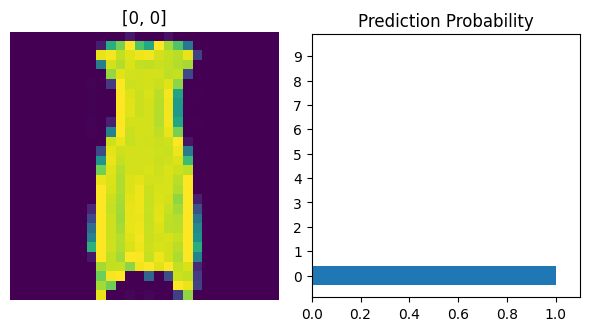

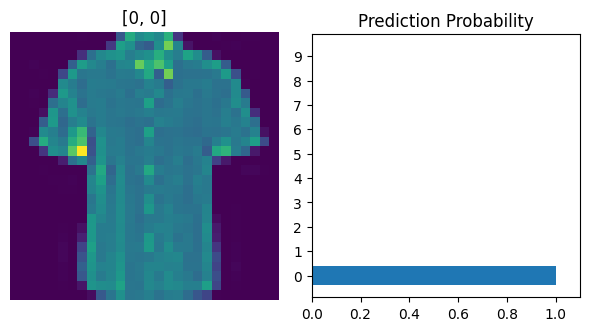

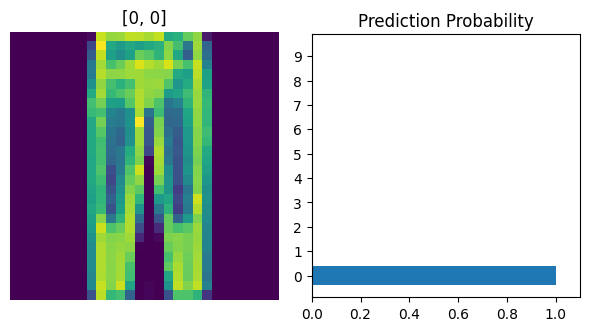

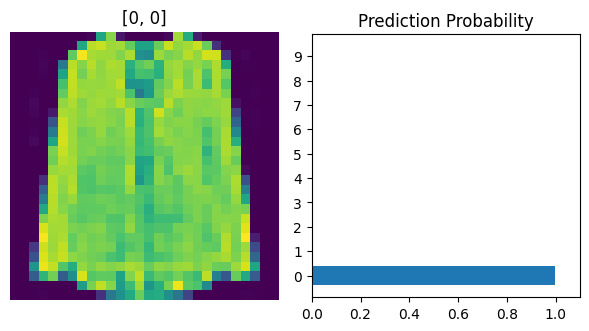

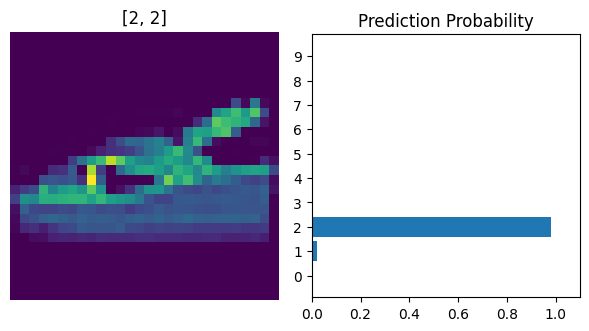

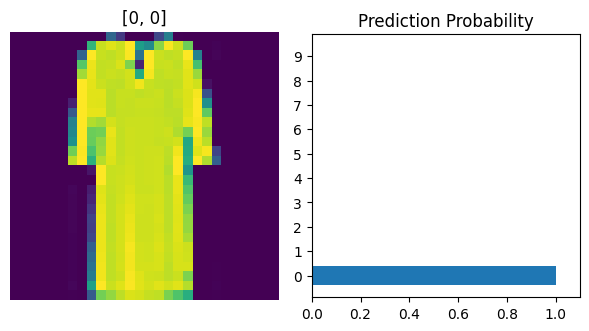

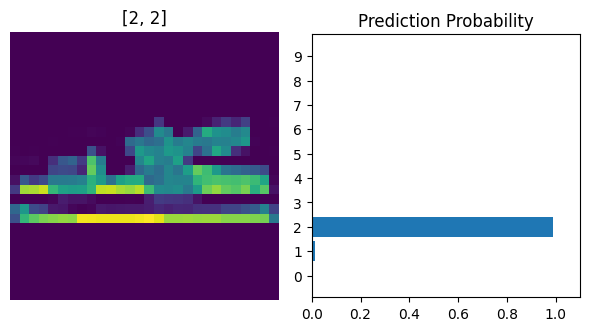

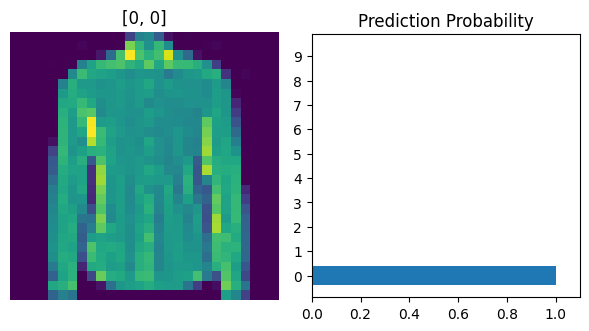

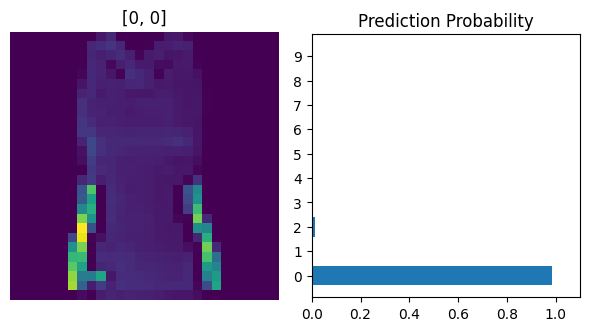

In [ ]:
model_2.to('cpu')

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_2(image_batch)
for i in range(10):
    img = image_batch[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)

### Does CNN use "Visual Information" ?

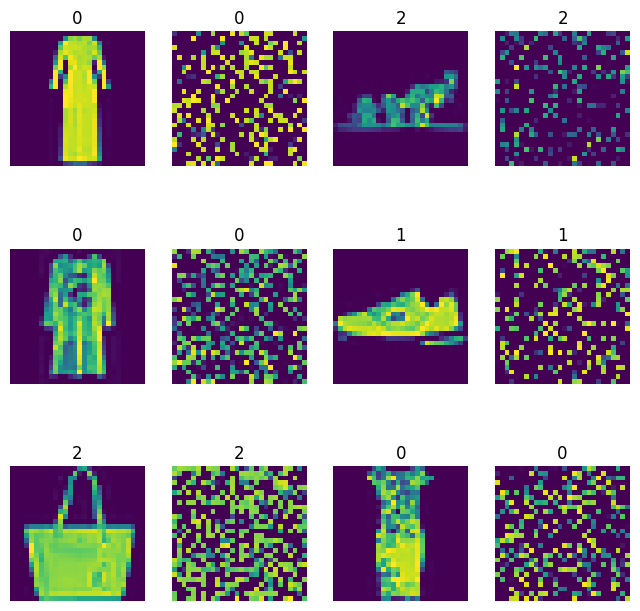

In [ ]:
fixed_perm = torch.randperm(784) # Fix a permutation of the image pixels; We apply the same permutation to all images

# show some training images
plt.figure(figsize=(8, 8))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(6):
    image = image_batch[i]
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, fixed_perm]
    image_perm = image_perm.view(-1, 1, 28, 28)

    label = label_batch[i].item()
    plt.subplot(3,4 , 2*i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)
    plt.subplot(3, 4, 2*i+2)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')
    plt.title(label)

In [ ]:
accuracy_list = []

def scramble_train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def scramble_test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [ ]:
print("Training on ", device)
model_cnn_3 = CNN(input_size, output_size)
model_cnn_3.to(device)
optimizer = optim.SGD(model_cnn_3.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn_3)))

for epoch in range(0, 10):
    scramble_train(epoch, model_cnn_3, fixed_perm)
    scramble_test(model_cnn_3, fixed_perm)

Training on  cuda:0
Number of parameters: 145826
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.271651
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.391075
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.211839
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.334096
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.160832
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.306239
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.190113
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.160602
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.079103
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.127838

Test set: Average loss: 0.1187, Accuracy: 9609/10000 (96%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.059053
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.226261
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.052963
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.058086
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.088311
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.085345
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.046604
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.015613
Tr

### Performance decreased from 99% to 98%

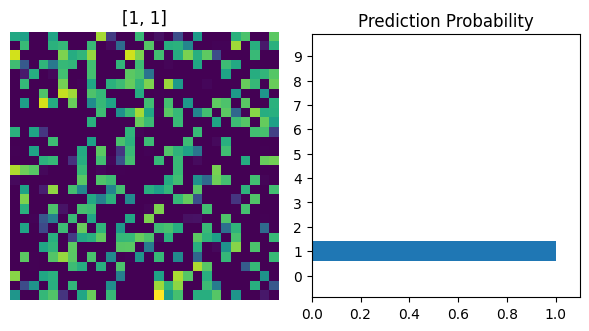

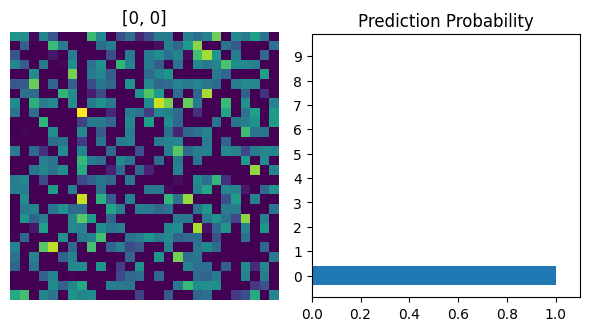

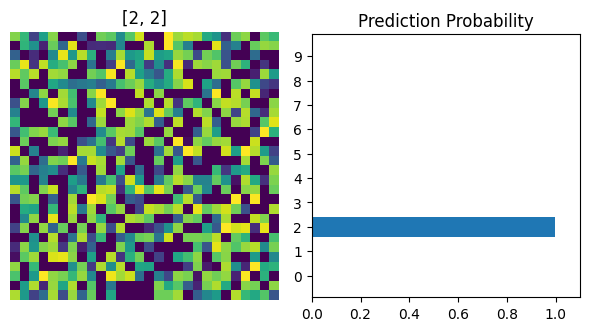

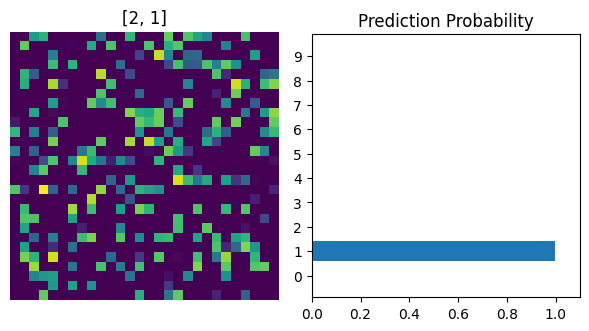

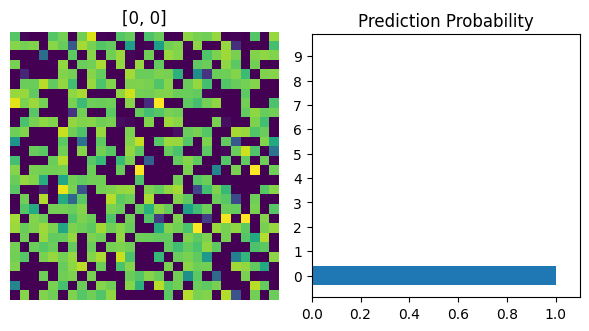

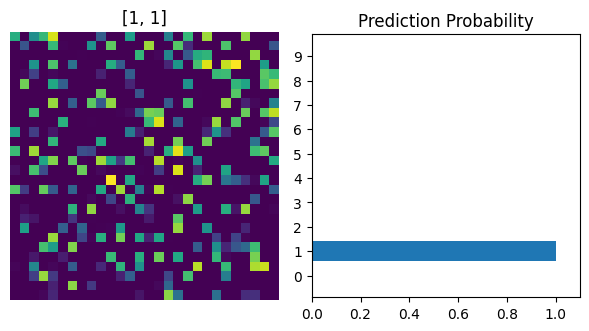

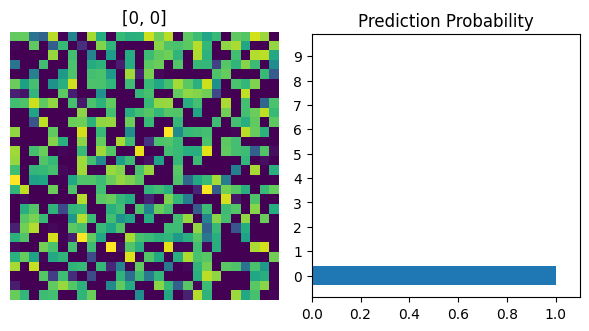

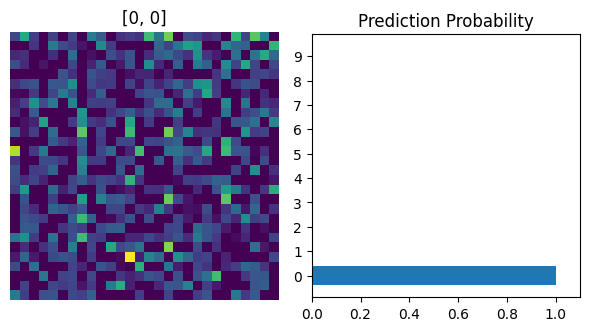

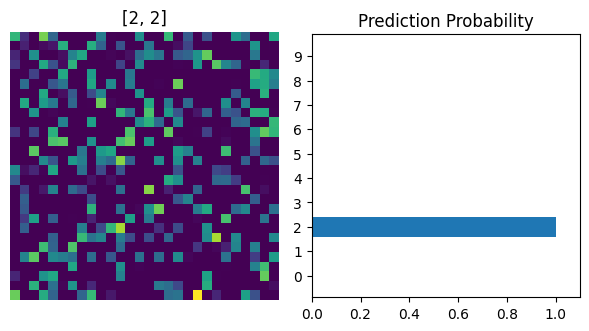

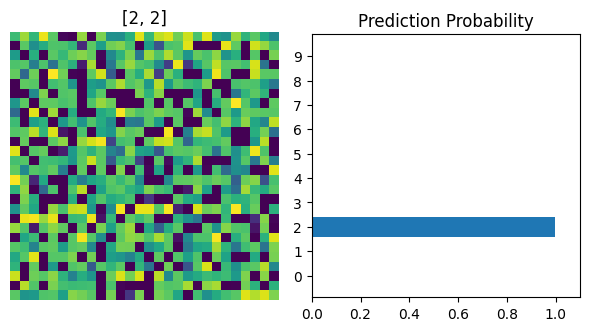

In [ ]:
model_cnn_3.to('cpu')

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))
image_batch_scramble = image_batch.view(-1, 28*28)
image_batch_scramble = image_batch_scramble[:, fixed_perm]
image_batch_scramble = image_batch_scramble.view(-1, 1, 28, 28)
# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_cnn_3(image_batch_scramble)
for i in range(10):
    img = image_batch[i]
    img_perm = image_batch_scramble[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img_perm, pred_prob, real_label)

In [ ]:
from collections import Counter

# Initialize the counter
label_counter = Counter()

# Iterate through the entire train dataset to count occurrences of each new label
for _, label in train_loader.dataset:
    label_counter[label] += 1

# Print the number of "clothes", "shoes", and "others"
print(f"Clothes: {label_counter[0]}")
print(f"Shoes: {label_counter[1]}")
print(f"Others: {label_counter[2]}")
print("The dataset, now is highly imbalanced")

Clothes: 36000
Shoes: 12000
Others: 12000
The dataset now is highly imbalanced


## With Data Augmentation for the minority classes: 1 and 2

In [ ]:
# Custom transformation for minority classes
augmentation_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Standard transformations for the majority class
standard_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Custom dataset class for applying augmentation only to minority classes (1: shoes, 2: others)
class AugmentedFashionMNIST(Dataset):
    def __init__(self, root, train=True, transform=None):
        self.dataset = datasets.FashionMNIST(root=root, train=train, download=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, original_label = self.dataset[idx]
        new_label = map_labels(original_label)  # Map to your custom classes (0, 1, 2)

        # Apply augmentation only to minority classes (1: shoes, 2: others)
        if new_label in [1, 2]:
            image = augmentation_transforms(image)
        else:
            image = standard_transforms(image)

        return image, new_label

# Use this new dataset for your train_loader
train_loader = torch.utils.data.DataLoader(AugmentedFashionMNIST('../data', train=True),
                                           batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(AugmentedFashionMNIST('../data', train=False),
                                          batch_size=1000, shuffle=True)

In [ ]:
from collections import Counter

# Initialize the counter
label_counter = Counter()

# Iterate through the entire train dataset to count occurrences of each new label
for _, label in train_loader.dataset:
    label_counter[label] += 1

# Print the number of "clothes", "shoes", and "others"
print(f"Clothes: {label_counter[0]}")
print(f"Shoes: {label_counter[1]}")
print(f"Others: {label_counter[2]}")
print("The dataset, now is highly imbalanced")

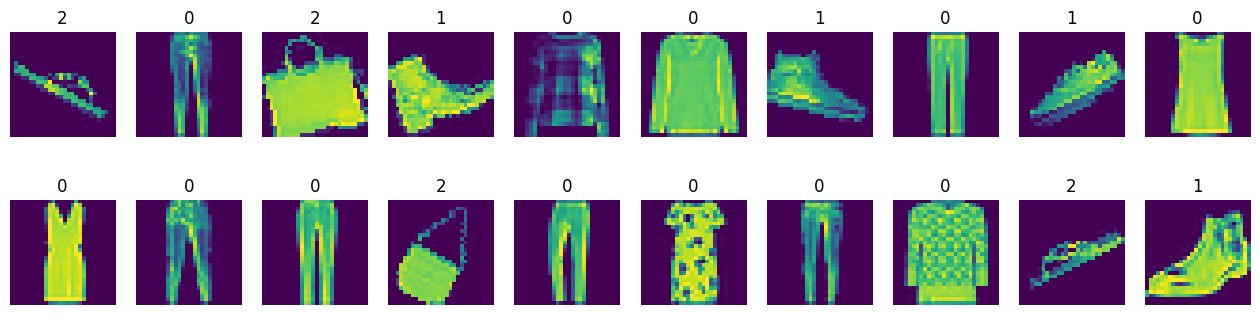

In [ ]:
# show some training images
plt.figure(figsize=(16, 4))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(20):
    image = image_batch[i]
    label = label_batch[i].item()
    plt.subplot(2, 10, i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)

In [ ]:
print("Training on ", device)
model_cnn = CNN(input_size, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 10):
    train(epoch, model_cnn)
    test(model_cnn)

Training on  cuda:0
Number of parameters: 145826
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.309613
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.524634
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.257107
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.291294
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.113342
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.123792
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.162039
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.041531
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.329270
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.160551

Test set: Average loss: 0.1233, Accuracy: 9561/10000 (96%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.148324
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.036341
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.100343
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.103288
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.055681
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.053518
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.185403
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.067867
Tr

### Data Augmentation with Dropout

In [ ]:
print("Training on ", device)
model_2 = CNNDropout(input_size, output_size)
model_2.to(device)
optimizer = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_2)))

for epoch in range(0, 10):
    model_2.train() # model in training mode. Turns on dropout, batch-norm etc during training
    train(epoch, model_2)
    model_2.eval() # model in evaluation mode. Turn off dropout, batch-norm etc during validation/testing
    test(model_2)

Training on  cuda:0
Number of parameters: 145826
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.315339
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.750698
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.354500
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.223495
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.229215
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.308817
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.092982
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.106430
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.139856
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.204682

Test set: Average loss: 0.1243, Accuracy: 9565/10000 (96%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.162966
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.144683
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.134328
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.143931
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.158583
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.096066
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.092349
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.228145
Tr

### CNN on Scrambled and augmented dataset

In [ ]:
print("Training on ", device)
model_cnn_3 = CNN(input_size, output_size)
model_cnn_3.to(device)
optimizer = optim.SGD(model_cnn_3.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn_3)))

for epoch in range(0, 10):
    scramble_train(epoch, model_cnn_3, fixed_perm)
    scramble_test(model_cnn_3, fixed_perm)

Training on  cuda:0
Number of parameters: 145826
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.333088
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.776163
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.391612
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.376713
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.263900
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.205383
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.167022
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.202987
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.162123
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.102933

Test set: Average loss: 0.1362, Accuracy: 9532/10000 (95%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.183778
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.122766
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.070847
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.243707
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.162147
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.102130
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.175728
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.134392
Tr

# Part-2 Resnet 18 classifier for emotion detection

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torchvision

In [2]:
import zipfile
import os
from PIL import Image
import torchvision
import matplotlib.pyplot as plt

In [4]:
# Step 2: Extract the zip file
zip_path = '/content/drive/MyDrive/archive.zip'  # Path to your zip file
extract_path = '/content/dataset/'               # Path where the dataset will be extracted

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

tot = 0

# Step 3: List all extracted files (just to verify extraction worked)
for root, dirs, files in os.walk(extract_path):
    for file in files:
        tot+=1

print(tot)

35887


In [5]:
# # Install PyTorch XLA for TPU support (this step is optional in most cases, as Colab pre-installs it)
# !pip install cloud-tpu-client==0.10 torch==2.0.0 torchvision==0.15.1 torchaudio==2.0.1 torch-xla==2.0.0

# # Import necessary libraries for PyTorch and TPU

# import torch_xla
# import torch_xla.core.xla_model as xm
# import torch_xla.distributed.xla_multiprocessing as xmp
# import torch_xla.distributed.parallel_loader as pl
# import torch_xla.utils.utils as xu
# import torch_xla.debug.metrics as met









ERROR: Could not find a version that satisfies the requirement torch-xla==2.0.0 (from versions: 2.1.0rc5, 2.1.0, 2.2.0, 2.3.0, 2.4.0)

ERROR: No matching distribution found for torch-xla==2.0.0



In [3]:
# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Custom Dataset/Preprocessing

In [4]:
input_size  = 28*28
output_size = 7

class CustomDataset(Dataset):
    def __init__(self, data_root, transform=None):
        self.data_root = data_root
        self.transform = transform
        self.images = []
        self.labels = []

        # Explicit mapping from class names to numeric labels
        self.class_to_idx = {
            "angry": 0,
            "disgusted": 1,
            "fearful": 2,
            "happy": 3,
            "neutral": 4,
            "sad": 5,
            "surprised": 6
        }

        # Loop through each class folder and gather image paths and labels
        for class_name, idx in self.class_to_idx.items():
            class_folder = os.path.join(data_root, class_name)
            if os.path.isdir(class_folder):
                for image_file in os.listdir(class_folder):
                    image_path = os.path.join(class_folder, image_file)
                    if image_file.endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(image_path)
                        self.labels.append(idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path).convert('L')  # Convert to grayscale (black and white)

        if self.transform:
            image = self.transform(image)

        label = self.labels[index]
        return image, label

# Define the transformations (Resize, convert to tensor)
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

# Initialize the custom dataset for training and testing
train_dataset = CustomDataset(data_root='/kaggle/input/emotion-detection-fer/train', transform=transform)
test_dataset = CustomDataset(data_root='/kaggle/input/emotion-detection-fer/test', transform=transform)

# Create DataLoader for train and test sets
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, num_workers=2)

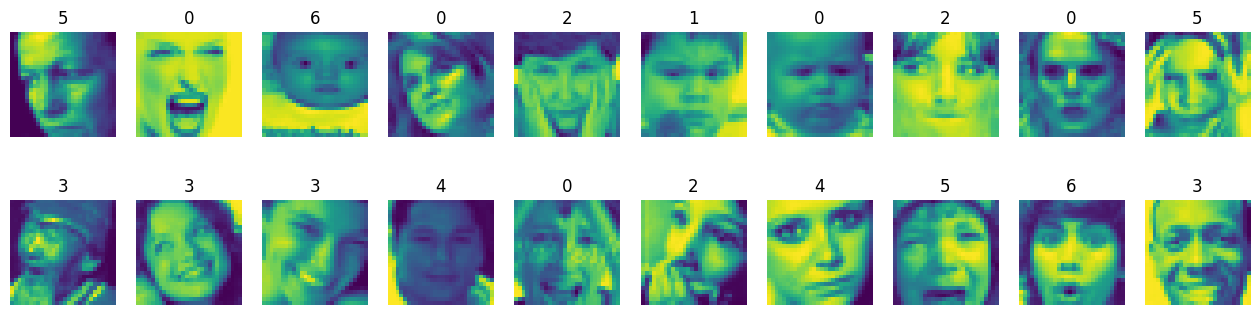

In [5]:
# show some training images
plt.figure(figsize=(16, 4))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(20):
    image = image_batch[i]
    label = label_batch[i].item()
    plt.subplot(2, 10, i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)

## Custom CNN Classifier

In [7]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

accuracy_list = []

# we pass a model object to this trainer, and it trains this model for one epoch
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        #loss = F.nll_loss(output, target)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        output = model(data)
        #test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        test_loss += F.cross_entropy(output, target, reduction='sum').item()
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [17]:
class CNNDropout(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3,padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=6,padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=6,padding=0)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=6,padding=0)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=6,padding=0)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=6,padding=0)
        self.fc1 = nn.Linear(512*4, 200)
        self.do1 = nn.Dropout2d(p=0.5)
        self.fc2 = nn.Linear(200, 7)

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv6(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 512*4)
        x = self.fc1(x)
        x = self.do1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [18]:
print("Training on ", device)
model_cnn = CNN(input_size, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 10):
    train(epoch, model_cnn)
    test(model_cnn)

Training on  cuda:0

Number of parameters: 145223

Train Epoch: 0 [0/28709 (0%)]	Loss: 1.960899

Train Epoch: 0 [6400/28709 (22%)]	Loss: 1.809379

Train Epoch: 0 [12800/28709 (45%)]	Loss: 1.732512

Train Epoch: 0 [19200/28709 (67%)]	Loss: 1.826007

Train Epoch: 0 [25600/28709 (89%)]	Loss: 1.849392



Test set: Average loss: 1.8161, Accuracy: 1774/7178 (25%)



Train Epoch: 1 [0/28709 (0%)]	Loss: 1.755235

Train Epoch: 1 [6400/28709 (22%)]	Loss: 1.779361

Train Epoch: 1 [12800/28709 (45%)]	Loss: 1.740699

Train Epoch: 1 [19200/28709 (67%)]	Loss: 1.796431

Train Epoch: 1 [25600/28709 (89%)]	Loss: 1.792928



Test set: Average loss: 1.8068, Accuracy: 1774/7178 (25%)



Train Epoch: 2 [0/28709 (0%)]	Loss: 1.875398

Train Epoch: 2 [6400/28709 (22%)]	Loss: 1.777689

Train Epoch: 2 [12800/28709 (45%)]	Loss: 1.758784

Train Epoch: 2 [19200/28709 (67%)]	Loss: 1.808858

Train Epoch: 2 [25600/28709 (89%)]	Loss: 1.772264



Test set: Average loss: 1.7886, Accuracy: 1801/7178 (25%)



Train Epoch: 

## Pretrain a Resnet-18 model from scratch

In [25]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=7):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(BasicBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [26]:
model = ResNet18()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch} loss: {running_loss / len(train_loader)}')

Epoch 0 loss: 1.5796046586238461

Epoch 1 loss: 1.3187850562395125

Epoch 2 loss: 1.1520123784419953

Epoch 3 loss: 0.99272963942292

Epoch 4 loss: 0.833747582937402

Epoch 5 loss: 0.6664321517492987

Epoch 6 loss: 0.5242610024184586

Epoch 7 loss: 0.4107894770518974

Epoch 8 loss: 0.31150652416763963

Epoch 9 loss: 0.23318432537809777


In [27]:
correct = 0
total = 0

# Set the model to evaluation mode (disable dropout, batch norm, etc.)
model.eval()

with torch.no_grad():  # Disable gradient calculation for evaluation
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)

        # Get the predicted class (the index of the maximum output value)
        _, predicted = torch.max(outputs.data, 1)

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 53.48%


## On a Pretrained Resnet-18 model

In [14]:
# Define device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for your dataset (resize to 224x224 for ResNet)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects input size of 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])  # Adjust for grayscale images (1 channel)
])

# Load the Pretrained ResNet-18 Model
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer to accept 1-channel images (grayscale)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

with torch.no_grad():
    model.conv1.weight[:, 0, :, :] = model.conv1.weight.mean(dim=1)  # Average the original RGB weights

# Modify the final fully connected layer to match the number of classes (7 classes for emotions)
num_ftrs = model.fc.in_features  
model.fc = nn.Linear(num_ftrs, 7)  
model = model.to(device)  

# Define the Loss function and Optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the Model; fine-tuning
def train(model, train_loader, criterion, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total
        print(f'Epoch [{epoch+1}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

# Evaluate the Model's Accuracy on the Test Set
def evaluate_accuracy(model, test_loader):
    correct = 0
    total = 0
    model.eval()  
    
    with torch.no_grad():  
        for data in test_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

# Train the model (optional if you're fine-tuning the model)
train(model, train_loader, criterion, optimizer, num_epochs=60)

# Evaluate the model on the test set
evaluate_accuracy(model, test_loader)

Epoch [1], Loss: 1.7258, Accuracy: 31.23%
Epoch [2], Loss: 1.5731, Accuracy: 38.73%
Epoch [3], Loss: 1.4955, Accuracy: 42.23%
Epoch [4], Loss: 1.4293, Accuracy: 45.05%
Epoch [5], Loss: 1.4021, Accuracy: 46.94%
Epoch [6], Loss: 1.3487, Accuracy: 49.02%
Epoch [7], Loss: 1.2668, Accuracy: 52.18%
Epoch [8], Loss: 1.2089, Accuracy: 54.72%
Epoch [9], Loss: 1.1444, Accuracy: 57.20%
Epoch [10], Loss: 1.1098, Accuracy: 58.92%
Epoch [11], Loss: 0.9781, Accuracy: 64.12%
Epoch [12], Loss: 0.9740, Accuracy: 64.50%
Epoch [13], Loss: 0.8187, Accuracy: 70.34%
Epoch [14], Loss: 0.6393, Accuracy: 77.15%
Epoch [15], Loss: 0.5141, Accuracy: 81.67%
Epoch [16], Loss: 0.4052, Accuracy: 85.67%
Epoch [17], Loss: 0.3161, Accuracy: 89.23%
Epoch [18], Loss: 0.2974, Accuracy: 89.78%
Epoch [19], Loss: 0.4088, Accuracy: 85.86%
Epoch [20], Loss: 0.2709, Accuracy: 90.65%
Epoch [21], Loss: 0.1516, Accuracy: 94.88%
Epoch [22], Loss: 0.1511, Accuracy: 94.88%
Epoch [23], Loss: 0.1220, Accuracy: 95.91%
Epoch [24], Loss: 0.